In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dsmanipulator import dsanalyzer as dsa
from dsmanipulator import dsloader as dsl
from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import FileColumnNames

In [2]:
fcn=FileColumnNames("TimeStamp", "Relative Time", "srcIP", "dstIP", "srcPort", "dstPort")

filename="../data/13122018-mega104-ioa.csv"

dialect = dsl.detect_dialect(filename)
df = dsl.load_data(
    filename,
    data_types={
        "TimeStamp": "datetime",
        "Relative Time": "float",
        "srcIP": "object",
        "dstIP": "object",
        "srcPort": "float",
        "dstPort": "float",
        "ipLen": "float",
        "len": "float",
        "fmt": "object",
        "uType": "object",
        "asduType": "float",
        "numix": "float",
        "cot": "float",
        "oa": "float",
        "addr": "float",
        "ioa": "object",
    },
    dialect=dialect,
)

dsc.add_relative_days(df, fcn, inplace=True)
station_ids = dsc.create_station_ids(df, fcn)
dsc.add_station_id(df, fcn, station_ids, inplace=True)
pair_ids = dsc.create_pair_ids(df, fcn)
dsc.add_pair_id(df, fcn, pair_ids, inplace=True)
direction_ids = dsc.create_direction_ids(df, fcn)
dsc.add_direction_id(df, fcn, direction_ids, inplace=True)


,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,len,fmt,uType,...,numix,cot,oa,addr,ioa,*Relative Day##,*Source station id##,*Destination station id##,*Pair id##,*Direction id##
0,2022-04-28 17:57:29.390,4.789799,192.168.11.111,192.168.11.248,49849.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,13,0,19
1,2022-04-28 17:57:29.400,4.790471,192.168.11.248,192.168.11.111,2404.0,49849.0,61.0,19.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,13,0,0,7
2,2022-04-28 17:57:29.400,4.790706,192.168.11.111,192.168.11.248,49849.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,13,0,19
3,2022-04-28 17:57:29.400,4.791022,192.168.11.248,192.168.11.111,2404.0,49849.0,62.0,20.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,13,0,0,7
4,2022-04-28 17:57:29.460,4.852302,192.168.11.111,192.168.11.248,49849.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,0,0,13,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460824,2022-05-01 17:15:02.230,256657.621521,192.168.11.111,192.168.11.248,56693.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,3,12,13,11,8
1460825,2022-05-01 17:15:02.260,256657.658087,192.168.11.248,192.168.11.111,2404.0,56693.0,60.0,18.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,3,13,12,11,1
1460826,2022-05-01 17:15:02.260,256657.658292,192.168.11.111,192.168.11.248,56693.0,2404.0,59.0,17.0,0x00000000,NaN,...,1.0,13.0,0.0,65535.0,65537,3,12,13,11,8
1460827,2022-05-01 17:15:02.260,256657.658611,192.168.11.248,192.168.11.111,2404.0,56693.0,46.0,4.0,0x00000001,NaN,...,NaN,NaN,NaN,NaN,NaN,3,13,12,11,1


In [3]:
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.axes import Axes

import numpy as np
import pandas as pd
import seaborn as sns

from dsmanipulator import dscreator as dsc
from dsmanipulator.utils import FileColumnNames, Station


from bidict import bidict

def plot_slaves(
    df: pd.DataFrame,
    fcn: FileColumnNames,
    axes: Axes,
    resample_rate: pd.Timedelta,
    master_station_id: int,
    station_ids: bidict[int, Station],
    pair_ids: bidict[int, frozenset],
) -> None:
    #     # TODO doc

    tmpdf = dsc.expand_values_to_columns(df, fcn.pair_id, drop_column=True)

    # names of expanded columns
    expanded_cols: list[str] = list(filter(lambda x: fcn.pair_id in x, tmpdf.columns))

    # filter only timestamp and expanded columns
    tmpdf = tmpdf[[fcn.timestamp] + expanded_cols]

    # rename columns to create legend
    new_col_names = {}
    for old_col_name in expanded_cols:
        x, y = pair_ids[int(old_col_name.rsplit(":", 1)[1])]
        slave_station_id = x if master_station_id == y else y
        new_col_names[old_col_name] = str(station_ids[slave_station_id])

    tmpdf.rename(columns=new_col_names, inplace=True)

    tmpdf = dsc.convert_to_timeseries(tmpdf, fcn)
    tmpdf = tmpdf.resample(resample_rate).sum()

    axes.xaxis.set_major_locator(AutoDateLocator())
    axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

    axes.legend([], [], frameon=False)

    sns.lineplot(data=tmpdf, palette="tab10", linewidth=3, ax=axes)

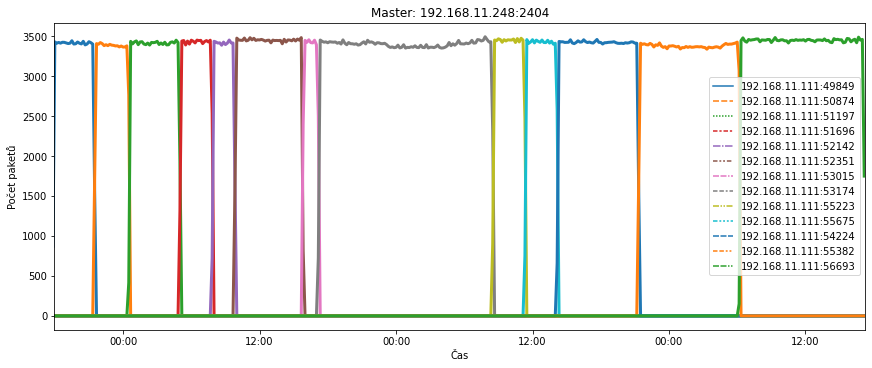

In [4]:
from datetime import timedelta
fig, ax = plt.subplots(1,1,figsize=(12, 5),constrained_layout = True)
# axs.set_xlim([data.start_dt, data.end_dt])

start = df[fcn.timestamp].iloc[0]
end = df[fcn.timestamp].iloc[-1]

ax.set_xlim([start, end])



plot_slaves(
    df,
    fcn,
    ax,
    timedelta(minutes=10),
    13,
    station_ids,
    pair_ids,
)

ax.set_title("Master: 192.168.11.248:2404")
ax.set_xlabel("Čas")
ax.set_ylabel("Počet paketů")


ax.legend(loc='center right')

for line in ax.lines:
    line.set_linestyle('solid')

plt.plot()


plt.savefig('pgf/slaves_plot.pgf')


In [5]:
df["oa"].value_counts() 
station_ids


bidict({0: Station(ip='192.168.11.111', port=49849.0), 1: Station(ip='192.168.11.111', port=50874.0), 2: Station(ip='192.168.11.111', port=51197.0), 3: Station(ip='192.168.11.111', port=51696.0), 4: Station(ip='192.168.11.111', port=52142.0), 5: Station(ip='192.168.11.111', port=52351.0), 6: Station(ip='192.168.11.111', port=53015.0), 7: Station(ip='192.168.11.111', port=53174.0), 8: Station(ip='192.168.11.111', port=54224.0), 9: Station(ip='192.168.11.111', port=55223.0), 10: Station(ip='192.168.11.111', port=55382.0), 11: Station(ip='192.168.11.111', port=55675.0), 12: Station(ip='192.168.11.111', port=56693.0), 13: Station(ip='192.168.11.248', port=2404.0)})